# DBSCAN Clustering with PyCaret

This notebook demonstrates DBSCAN (Density-Based Spatial Clustering of Applications with Noise) using the PyCaret library. DBSCAN automatically discovers clusters based on density and identifies outliers.

**Objective**: Apply density-based clustering to find arbitrarily shaped clusters and detect outliers/noise points without specifying the number of clusters beforehand.

In [1]:
# Installing PyCaret
!pip install git+https://github.com/pycaret/pycaret.git@master --upgrade -q

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.clustering import *
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_score

# Setting style
sns.set_style("whitegrid")
np.random.seed(42)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Data Generation

Generating synthetic data with non-spherical (moon-shaped) clusters to demonstrate DBSCAN's ability to find arbitrarily shaped clusters, which K-Means and GMM cannot handle well.

Data shape: (320, 2)

First 5 rows:
   Feature_1  Feature_2
0   0.682988  -0.345203
1   2.040990  -0.131615
2  -0.139752   0.454391
3   0.885748   0.286342
4   1.182459  -0.497711


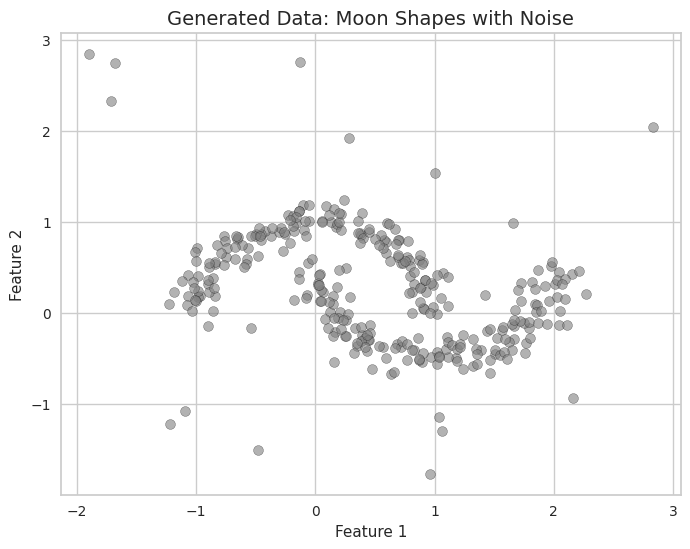

In [2]:
# Generating moon-shaped clusters with noise
X, true_labels = make_moons(n_samples=300, noise=0.1, random_state=42)

# Adding some outlier points manually
outliers = np.random.uniform(low=-2, high=3, size=(20, 2))
X = np.vstack([X, outliers])
true_labels = np.append(true_labels, [-1] * 20)  # -1 for outliers

# Creating DataFrame for PyCaret
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])

print(f"Data shape: {df.shape}")
print(f"\nFirst 5 rows:\n{df.head()}")

# Visualizing the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, edgecolors='k', s=50)
plt.title('Generated Data: Moon Shapes with Noise', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Setting Up PyCaret Clustering Environment

Initializing PyCaret's clustering module with the dataset. PyCaret simplifies the workflow by handling preprocessing and model setup automatically.

In [3]:
# Setting up PyCaret clustering environment
cluster_setup = setup(data=df,
                      normalize=True,  # Normalizing features
                      session_id=42,   # For reproducibility
                      verbose=False)   # Suppressing detailed output

print("PyCaret clustering environment initialized successfully!")

PyCaret clustering environment initialized successfully!


## Creating DBSCAN Model

Creating and training the DBSCAN model using PyCaret. The model will automatically determine the number of clusters based on data density.

In [5]:
# Creating DBSCAN model with custom parameters
dbscan_model = create_model('dbscan',
                            eps=0.3,           # Neighborhood radius
                            min_samples=5)      # Minimum points for dense region

# Getting cluster assignments
labels = assign_model(dbscan_model)
# Convert string labels to integers for proper numerical operations
cluster_labels_str = labels['Cluster'].values
cluster_labels = np.array([int(label.split(' ')[1]) for label in cluster_labels_str])

# Calculating number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\n{'='*50}")
print(f"DBSCAN Clustering Results")
print(f"{'='*50}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Cluster distribution: {np.bincount(cluster_labels[cluster_labels >= 0])}")

# Calculating Silhouette Score (excluding noise points)
if n_clusters > 1:
    mask = cluster_labels != -1
    if mask.sum() > 0:
        silhouette_avg = silhouette_score(X[mask], cluster_labels[mask])
        print(f"Silhouette Score (excluding noise): {silhouette_avg:.3f}")

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3236,78.1962,8.2152,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]


DBSCAN Clustering Results
Number of clusters found: 2
Number of noise points: 17
Cluster distribution: [151 152]
Silhouette Score (excluding noise): 0.325


## Visualizing DBSCAN Results

Plotting the clustering results with different colors for each cluster and highlighting noise points in red.

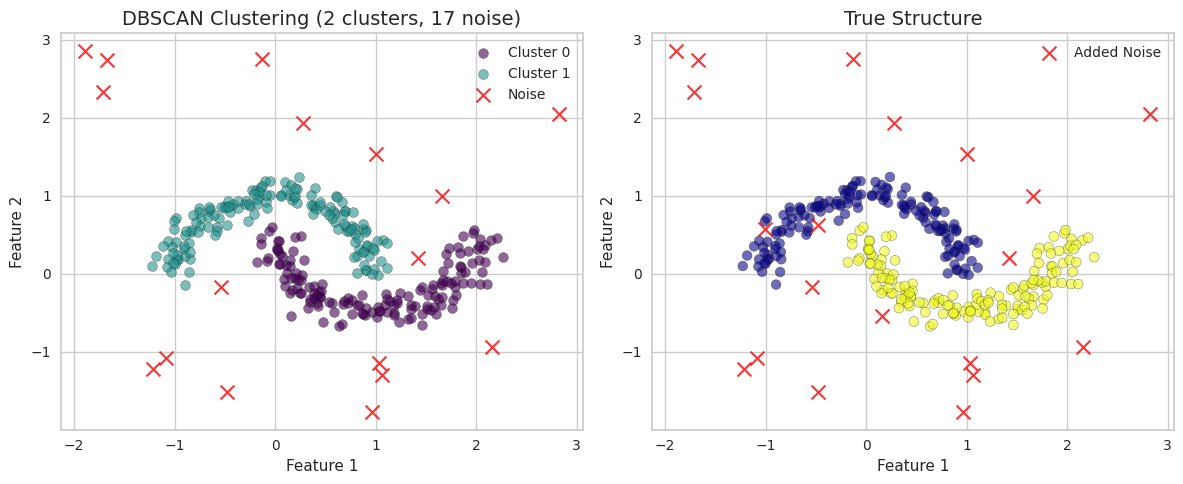

In [6]:
# Visualizing DBSCAN clustering results
plt.figure(figsize=(12, 5))

# Subplot 1: DBSCAN clusters
plt.subplot(1, 2, 1)
unique_labels = set(cluster_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points in red
        mask = cluster_labels == label
        plt.scatter(X[mask, 0], X[mask, 1], c='red', marker='x',
                   s=100, alpha=0.8, edgecolors='k', linewidths=1.5,
                   label='Noise')
    else:
        # Cluster points
        mask = cluster_labels == label
        plt.scatter(X[mask, 0], X[mask, 1], c=[color], alpha=0.6,
                   edgecolors='k', s=50, label=f'Cluster {label}')

plt.title(f'DBSCAN Clustering ({n_clusters} clusters, {n_noise} noise)', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Subplot 2: True structure (for comparison)
plt.subplot(1, 2, 2)
plt.scatter(X[true_labels >= 0, 0], X[true_labels >= 0, 1],
           c=true_labels[true_labels >= 0], cmap='plasma',
           alpha=0.6, edgecolors='k', s=50)
plt.scatter(X[true_labels == -1, 0], X[true_labels == -1, 1],
           c='red', marker='x', s=100, alpha=0.8,
           edgecolors='k', linewidths=1.5, label='Added Noise')
plt.title('True Structure', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

## Exploring PyCaret's Built-in Visualization

Using PyCaret's built-in plotting functions to visualize the DBSCAN results and explore cluster characteristics.

In [7]:
# Using PyCaret's built-in visualizations
print("PyCaret Cluster Visualization:")
plot_model(dbscan_model, plot='cluster')

# Displaying cluster distribution
print("\nCluster Distribution:")
plot_model(dbscan_model, plot='distribution')

print(f"\nDBSCAN successfully identified {n_clusters} clusters and {n_noise} outliers!")

PyCaret Cluster Visualization:



Cluster Distribution:



DBSCAN successfully identified 2 clusters and 17 outliers!
